## LRP with simple (single layer, with attention) LSTM
Author: Lin Lee Cheong
Date: 1/5/2020

Try to make sure I can run LRP correctly. Adapt Arras code to our use case.
1. Read in a pre-trained simple LSTM model
2. Define a LRP enabled model
3. Run relevances through the model
4. Add functionality to the LSTM model descriptor

In [1]:
import os
import time
import torch
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from urllib.parse import urlparse
import tarfile
import pickle
import shutil

import shap
import xgboost as xgb

import sagemaker
import boto3
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.image_uris import retrieve

import deep_id_pytorch

from lstm_models import *
from att_lstm_models import *
from lstm_utils import *
from xgboost_utils import *

All parameters

In [2]:
nrows = 1e9
min_freq = 1

seq_len = 30
train_data_path = "../../data/toy_dataset/data/{}/train.csv".format(seq_len)
valid_data_path = "../../data/toy_dataset/data/{}/val.csv".format(seq_len)
test_data_path = "../../data/toy_dataset/data/{}/test.csv".format(seq_len)
lstm_model_save_path = './output/{}/lstm/models/model'.format(seq_len)
batch_size = 64

n_epochs = 1
stop_num = 2

embedding_dim = 8
hidden_dim = 16
nlayers = 1
bidirectional = True
dropout = 0.3

target_colname = 'label'
uid_colname = 'patient_id'
x_inputs = [str(x) for x in range(29, -1, -1)]
target_value = '1'

rev = False

In [3]:
print(f"Cuda available: {torch.cuda.is_available()}")
model_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Cuda available: True


In [4]:
train_dataset, vocab = build_lstm_dataset(
                                train_data_path,
                                min_freq=min_freq,
                                uid_colname="patient_id",
                                target_colname="label",
                                max_len=seq_len,
                                target_value=target_value,
                                vocab=None,
                                nrows=nrows,
                                rev=rev
                            )
valid_dataset, _ = build_lstm_dataset(
                                valid_data_path,
                                min_freq=min_freq,
                                uid_colname="patient_id",
                                target_colname="label",
                                max_len=seq_len,
                                target_value=target_value,
                                vocab=vocab,
                                nrows=nrows,
                                rev=rev
                            )

test_dataset, _ = build_lstm_dataset(
                                test_data_path,
                                min_freq=min_freq,
                                uid_colname="patient_id",
                                target_colname="label",
                                max_len=seq_len,
                                target_value=target_value,
                                vocab=vocab,
                                nrows=nrows,
                                rev=rev
                            )

Building dataset from ../../data/toy_dataset/data/30/train.csv..
Success!
Building dataset from ../../data/toy_dataset/data/30/val.csv..
Success!
Building dataset from ../../data/toy_dataset/data/30/test.csv..
Success!


In [5]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

In [6]:
lstm_model = AttLSTM(
    embedding_dim, hidden_dim, vocab, 
    model_device, nlayers=nlayers, dropout=dropout,
    linear_bias=False)
lstm_model = lstm_model.cuda()

## Train LSTM model

In [7]:
#loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.05)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.9)

In [8]:
best_valid_loss = float("inf")
valid_worse_loss = 0  # enable early stopping


for epoch in range(n_epochs):

    start_time = time.time()

    train_loss, train_auc = epoch_train_lstm(
        lstm_model, train_dataloader, optimizer, loss_function
    )

    valid_loss, valid_auc = epoch_val_lstm(
       lstm_model, valid_dataloader, loss_function)#, return_preds=False
    #)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(lstm_model.state_dict(), lstm_model_save_path)
        print("Saved Model, epoch {}".format(epoch))
        valid_worse_loss = 0

    else:
        valid_worse_loss += 1
        if valid_worse_loss == stop_num:
            print("EARLY STOP ------")
            break

    scheduler.step()
    print(
        f"Train Loss: {train_loss:.3f} | Train AUC: {train_auc:.2f} \t Val. Loss: {valid_loss:.3f} |  Val. AUC: {valid_auc:.4f}"
    )

Epoch: 01 | Epoch Time: 0m 5s
Saved Model, epoch 0
Train Loss: 0.390 | Train AUC: 0.89 	 Val. Loss: 0.310 |  Val. AUC: 0.9110


In [9]:
lstm_model.load_state_dict(torch.load(lstm_model_save_path))

<All keys matched successfully>

In [10]:
lstm_model

AttLSTM(
  (emb_layer): Embedding(32, 8, padding_idx=0)
  (lstm): LSTM(8, 16, batch_first=True, dropout=0.3, bidirectional=True)
  (pred_layer): Linear(in_features=64, out_features=1, bias=False)
  (dpt): Dropout(p=0.3, inplace=False)
)

## Define LRP LSTM model

In [12]:
lstm_model = lstm_model.cpu()

In [13]:
import numpy as np
from numpy import newaxis as na


def lrp_linear(hin, w, b, hout, Rout, bias_nb_units, eps, bias_factor=0.0, debug=False):
    """
    LRP for a linear layer with input dim D and output dim M.
    Args:
    - hin:            forward pass input, of shape (D,)
    - w:              connection weights, of shape (D, M)
    - b:              biases, of shape (M,)
    - hout:           forward pass output, of shape (M,) (unequal to np.dot(w.T,hin)+b if more than one incoming layer!)
    - Rout:           relevance at layer output, of shape (M,)
    - bias_nb_units:  total number of connected lower-layer units (onto which the bias/stabilizer contribution is redistributed for sanity check)
    - eps:            stabilizer (small positive number)
    - bias_factor:    set to 1.0 to check global relevance conservation, otherwise use 0.0 to ignore bias/stabilizer redistribution (recommended)
    Returns:
    - Rin:            relevance at layer input, of shape (D,)
    """
    sign_out = np.where(hout[na,:]>=0, 1., -1.) # shape (1, M)
    
    numer    = (w * hin[:,na]) + ( bias_factor * (b[na,:]*1. + eps*sign_out*1.) / bias_nb_units ) # shape (D, M)
    # Note: here we multiply the bias_factor with both the bias b and the stabilizer eps since in fact
    # using the term (b[na,:]*1. + eps*sign_out*1.) / bias_nb_units in the numerator is only useful for sanity check
    # (in the initial paper version we were using (bias_factor*b[na,:]*1. + eps*sign_out*1.) / bias_nb_units instead)
    
    denom    = hout[na,:] + (eps*sign_out*1.)   # shape (1, M)
    
    message  = (numer/denom) * Rout[na,:]       # shape (D, M)
    
    Rin      = message.sum(axis=1)              # shape (D,)
    
    if debug:
        print("local diff: ", Rout.sum() - Rin.sum())
    # Note: 
    # - local  layer   relevance conservation if bias_factor==1.0 and bias_nb_units==D (i.e. when only one incoming layer)
    # - global network relevance conservation if bias_factor==1.0 and bias_nb_units set accordingly to the total number of lower-layer connections 
    # -> can be used for sanity check
    
    return Rin

In [744]:
for param, _ in lstm_model.named_parameters():
    print(f"{param} >>> {_.shape}")

emb_layer.weight >>> torch.Size([32, 8])
lstm.weight_ih_l0 >>> torch.Size([64, 8])
lstm.weight_hh_l0 >>> torch.Size([64, 16])
lstm.bias_ih_l0 >>> torch.Size([64])
lstm.bias_hh_l0 >>> torch.Size([64])
lstm.weight_ih_l0_reverse >>> torch.Size([64, 8])
lstm.weight_hh_l0_reverse >>> torch.Size([64, 16])
lstm.bias_ih_l0_reverse >>> torch.Size([64])
lstm.bias_hh_l0_reverse >>> torch.Size([64])
pred_layer.weight >>> torch.Size([1, 64])


In [679]:
class LSTM_ARP:
    def __init__(self, pymodel):
        super(LSTM_ARP, self).__init__()
        
        self.bidi = True
        self.nlayers = 1 #only supports 1 right now
        
        self.init_model(pymodel)
    
    def init_model(self, pymodel):
        
        self.device = pymodel.device
        self.use_gpu = pymodel.use_gpu
        
        self.emb_dim = pymodel.emb_dim
        self.vocab = pymodel.vocab
        self.input_dim = len(self.vocab)
        self.pad_idx = pymodel.pad_idx        
        self.hidden_dim = pymodel.hidden_dim
        
        self.emb = pymodel.emb_layer.weight.detach().numpy()
        
        param_list = list(pymodel.lstm.named_parameters())
        param_dict = {}
        for param_tuple in param_list:
            param_dict[param_tuple[0]] = param_tuple[-1].detach().numpy()
        
        # rearrange, pytorch uses ifgo format, need to move to icfo/igfo format
        idx_list = (
            list(range(0, self.hidden_dim)) + 
            list(range(self.hidden_dim*2, self.hidden_dim*3)) +
            list(range(self.hidden_dim, self.hidden_dim*2)) +
            list(range(self.hidden_dim*3, self.hidden_dim*4))
        )
        
        # i (input), g (candidate), f (forget), o (output) order
        # (4 * hidden_dim, emb_dim)
        self.Wxh_Left = param_dict['weight_ih_l0'][idx_list]
        self.bxh_Left  = param_dict["bias_ih_l0"][idx_list]  # shape 4d 
        self.Whh_Left  = param_dict["weight_hh_l0"][idx_list]  # shape 4d*d
        self.bhh_Left  = param_dict["bias_hh_l0"][idx_list]  # shape 4d  
        # LSTM right encoder
        self.Wxh_Right = param_dict["weight_ih_l0_reverse"][idx_list]
        self.bxh_Right = param_dict["bias_ih_l0_reverse"][idx_list]
        self.Whh_Right = param_dict["weight_hh_l0_reverse"][idx_list]
        self.bhh_Right = param_dict["bias_hh_l0_reverse"][idx_list] 
        
        # START ADDED: CONTEXT LAYER INIT
        # linear output layer: shape C * 4d
        # 0-d: fwd & context
        # d-2d: rev & context
        # 2d-3d: fwd & final hidden
        # 3d-4d: rev & final hidden
        Why = pymodel.pred_layer.weight.detach().numpy()
        
        self.Why_Left  = Why[:, 2 * self.hidden_dim: 3 * self.hidden_dim] # shape C*d
        self.Why_Right = Why[:, 3 * self.hidden_dim:] # shape C*d
        
        self.Wcy_Left = Why[:, :self.hidden_dim]
        self.Wcy_Right = Why[:, self.hidden_dim: 2 * self.hidden_dim]
        
        #Wcc = pymodel.attn_layer.weight.detach().numpy()
        #self.Wcc_Left = Wcc[:, :self.hidden_dim]
        #self.Wcc_Right = Wcc[:, self.hidden_dim:]
        # END ADDED: CONTEXT LAYER INIT
        
    def set_input(self, tokens):
        T      = len(tokens)                         # sequence length
        d      = int(self.Wxh_Left.shape[0]/4)  # hidden layer dimension
        e      = self.emb.shape[1]                # word embedding dimension
        
        x      = np.zeros((T, e))
        x[:,:] = self.emb[tokens,:]
        
        self.w              = tokens
        self.x              = x
        self.x_rev          = x[::-1,:].copy()
        
        self.h_Left         = np.zeros((T+1, d))
        self.c_Left         = np.zeros((T+1, d))
        self.h_Right        = np.zeros((T+1, d))
        self.c_Right        = np.zeros((T+1, d))        
        
    def forward_lrp(self):
        """
        Standard forward pass.
        Compute the hidden layer values (assuming input x/x_rev was previously set)
        """
        T      = len(self.w)                         
        d      = int(self.Wxh_Left.shape[0]/4) 
        
        # gate indices (assuming the gate ordering in the LSTM weights is i,g,f,o):     
        idx    = np.hstack((np.arange(0,d), np.arange(2*d,4*d))).astype(int) # indices of gates i,f,o together
        idx_i, idx_g, idx_f, idx_o = np.arange(0,d), np.arange(d,2*d), np.arange(2*d,3*d), np.arange(3*d,4*d) # indices of gates i,g,f,o separately
          
        # initialize
        self.gates_xh_Left  = np.zeros((T, 4*d))  
        self.gates_hh_Left  = np.zeros((T, 4*d)) 
        self.gates_pre_Left = np.zeros((T, 4*d))  # gates pre-activation
        self.gates_Left     = np.zeros((T, 4*d))  # gates activation
        
        self.gates_xh_Right = np.zeros((T, 4*d))  
        self.gates_hh_Right = np.zeros((T, 4*d)) 
        self.gates_pre_Right= np.zeros((T, 4*d))
        self.gates_Right    = np.zeros((T, 4*d)) 
             
        # START ADDED: INITIALIZE CONTEXT LAYERS
        self.ctxt_Left      = np.zeros((1, d))
        self.ctxt_Right     = np.zeros((1, d))
        self.att_wgt_Left   = np.zeros((T, 1))
        self.att_wgt_Right  = np.zeros((T, 1))
        self.att_score      = np.zeros((T, 1))
        
        # END ADDED: INITIALIZE CONTEXT LAYERS
        for t in range(T): 
            self.gates_xh_Left[t]     = np.dot(self.Wxh_Left, self.x[t])        
            self.gates_hh_Left[t]     = np.dot(self.Whh_Left, self.h_Left[t-1]) 
            self.gates_pre_Left[t]    = self.gates_xh_Left[t] + self.gates_hh_Left[t] + self.bxh_Left + self.bhh_Left
            self.gates_Left[t,idx]    = 1.0/(1.0 + np.exp(- self.gates_pre_Left[t,idx]))
            self.gates_Left[t,idx_g]  = np.tanh(self.gates_pre_Left[t,idx_g]) 
            self.c_Left[t]            = self.gates_Left[t,idx_f]*self.c_Left[t-1] + self.gates_Left[t,idx_i]*self.gates_Left[t,idx_g]
            self.h_Left[t]            = self.gates_Left[t,idx_o]*np.tanh(self.c_Left[t])
            
            self.gates_xh_Right[t]    = np.dot(self.Wxh_Right, self.x_rev[t])     
            self.gates_hh_Right[t]    = np.dot(self.Whh_Right, self.h_Right[t-1])
            self.gates_pre_Right[t]   = self.gates_xh_Right[t] + self.gates_hh_Right[t] + self.bxh_Right + self.bhh_Right
            self.gates_Right[t,idx]   = 1.0/(1.0 + np.exp(- self.gates_pre_Right[t,idx]))
            self.gates_Right[t,idx_g] = np.tanh(self.gates_pre_Right[t,idx_g])                 
            self.c_Right[t]           = self.gates_Right[t,idx_f]*self.c_Right[t-1] + self.gates_Right[t,idx_i]*self.gates_Right[t,idx_g]
            self.h_Right[t]           = self.gates_Right[t,idx_o]*np.tanh(self.c_Right[t])
            
        # START ADDED: CALCULATE ATTENTION LAYER
        self.att_wgt_Left    = np.dot(self.h_Left[:T, :], self.h_Left[T-1])
        self.att_wgt_Right   = np.dot(self.h_Right[:T, :], self.h_Right[T-1])
        
        self.att_score_int = (self.att_wgt_Left + self.att_wgt_Right) / (T ** 0.5) 
        self.att_score = np.exp(self.att_score_int) / np.sum(np.exp(self.att_score_int))
        # END ADDED: CALCULATE ATTENTION LAYER
        
        # START ADDED: CONTEXT LAYER CALCULATIONS
        #self.ctxt_Left  = np.dot(self.att_score[:, na].T, self.h_Left[:T])
        self.ctxt_Left  = (self.att_score[:, na] * self.h_Left[:T]).sum(axis=0)
        self.ctxt_Right = (self.att_score[:, na] * self.h_Right[:T]).sum(axis=0)
        #self.ctxt_Right = np.dot(self.att_score[:, na].T, self.h_Right[:T])        
        # END ADDED: CONTEXT LAYER CALCULATIONS
        
        # START MODIFIED: CALCULATE WITH CONTEXT & OUT, NOT JUST HIDDEN
        self.y_Left  = np.dot(self.Why_Left, self.h_Left[T-1]) 
        #self.y_Left += np.dot(self.Wcy_Left, self.ctxt_Left.squeeze(0))
        self.y_Left += np.dot(self.Wcy_Left, self.ctxt_Left)
        
        self.y_Right = np.dot(self.Why_Right, self.h_Right[T-1])
        #self.y_Right+= np.dot(self.Wcy_Right, self.ctxt_Right.squeeze(0))
        self.y_Right+= np.dot(self.Wcy_Right, self.ctxt_Right)
        
        self.s       = self.y_Left + self.y_Right
        
        return self.s.copy() # prediction scores  
    
    def lrp(self, w, LRP_class, eps=0.001, bias_factor=0.0):
        """
        Layer-wise Relevance Propagation (LRP) backward pass.
        Compute the hidden layer relevances by performing LRP for the target class LRP_class
        (according to the papers:
            - https://doi.org/10.1371/journal.pone.0130140
            - https://doi.org/10.18653/v1/W17-5221 )
        """
        # forward pass
        self.set_input(w)
        self.forward_lrp() 
        
        T      = len(self.w)
        d      = int(self.Wxh_Left.shape[0]/4)
        e      = self.emb.shape[1] 
        C      = self.Why_Left.shape[0]  # number of classes
        idx    = np.hstack((np.arange(0,d), np.arange(2*d,4*d))).astype(int) # indices of gates i,f,o together
        idx_i, idx_g, idx_f, idx_o = np.arange(0,d), np.arange(d,2*d), np.arange(2*d,3*d), np.arange(3*d,4*d) # indices of gates i,g,f,o separately
        
        # initialize
        Rx       = np.zeros(self.x.shape)
        Rx_rev   = np.zeros(self.x.shape)
        
        Rh_Left  = np.zeros((T+1, d))
        Rc_Left  = np.zeros((T+1, d))
        Rg_Left  = np.zeros((T,   d)) # gate g only
        Rh_Right = np.zeros((T+1, d))
        Rc_Right = np.zeros((T+1, d))
        Rg_Right = np.zeros((T,   d)) # gate g only
        
        Rctxt_Left = np.zeros((1, d))
        Rctxt_Right = np.zeros((1, d))
        
        Rout_mask            = np.zeros((C))
        Rout_mask[LRP_class] = 1.0  
        
        
        # format reminder: lrp_linear(hin, w, b, hout, Rout, bias_nb_units, eps, bias_factor)
        Rh_Left[T-1]  = lrp_linear(
            self.h_Left[T-1],  self.Why_Left.T, 
            np.zeros((C)), self.s, self.s*Rout_mask, 8*d, eps, bias_factor, debug=False
        )
        Rh_Right[T-1] = lrp_linear(
            self.h_Right[T-1], self.Why_Right.T, 
            np.zeros((C)), self.s, self.s*Rout_mask, 8*d, eps, bias_factor, debug=False
        )
        
        # ADD CONTEXT CALCULATIONS TO CONTEXT LAYER
        Rctxt_Left = lrp_linear(
            self.ctxt_Left, self.Wcy_Left.T,
            np.zeros((C)), self.s, self.s*Rout_mask, 8*d, eps, bias_factor, debug=False
        )
        
        Rctxt_Right = lrp_linear(
            self.ctxt_Right, self.Wcy_Right.T,
            np.zeros((C)), self.s, self.s*Rout_mask, 8*d, eps, bias_factor, debug=False
        )
                
        # ADD R TO Rh_Left and Rh_Right
        #Rh_Left[T-1]  += self.att_score[T-1] * Rctxt_Left / d
        #Rh_Right[T-1] += self.att_score[T-1] * Rctxt_Right / d
        
        Rh_Left[T-1] += lrp_linear(
            self.h_Left[T-1], np.identity((d)) , 
            np.zeros((d)), self.ctxt_Left, self.att_score[T-1] * Rctxt_Left, 
            d, eps, bias_factor, debug=False) 
        Rh_Right[T-1] += lrp_linear(
            self.h_Right[T-1], np.identity((d)) , 
            np.zeros((d)), self.ctxt_Right, self.att_score[T-1] *Rctxt_Right, 
            d, eps, bias_factor, debug=False)         
        
        # CORRECT FOR NUMBER OF NODES
        for t in reversed(range(T)):
            Rc_Left[t]   += Rh_Left[t]
            Rc_Left[t-1] += lrp_linear(
                self.gates_Left[t,idx_f]*self.c_Left[t-1], np.identity(d),
                np.zeros((d)), self.c_Left[t], Rc_Left[t], 
                2*d, eps, bias_factor, debug=False)
            
            Rg_Left[t]   += lrp_linear(
                self.gates_Left[t,idx_i]*self.gates_Left[t,idx_g], np.identity(d), 
                np.zeros((d)), self.c_Left[t], Rc_Left[t], 
                2*d, eps, bias_factor, debug=False)
            
            Rx[t]        += lrp_linear(
                self.x[t], self.Wxh_Left[idx_g].T, 
                self.bxh_Left[idx_g]+self.bhh_Left[idx_g], self.gates_pre_Left[t,idx_g], Rg_Left[t], 
                d+e, eps, bias_factor, debug=False)

            Rh_Left[t-1] += lrp_linear(
                self.h_Left[t-1], self.Whh_Left[idx_g].T, 
                self.bxh_Left[idx_g]+self.bhh_Left[idx_g], self.gates_pre_Left[t,idx_g], 
                Rg_Left[t], d+e, eps, bias_factor, debug=False)
            #Rh_Left[t-1] += self.att_score[t-1] * Rctxt_Left / d
            Rh_Left[t-1] += lrp_linear(
                self.h_Left[t-1] , np.identity((d)), 
                np.zeros((d)), self.ctxt_Left, self.att_score[t-1] *Rctxt_Left, 
                d, eps, bias_factor, debug=False)
            

            Rc_Right[t]  += Rh_Right[t]
            Rc_Right[t-1]+= lrp_linear(
                self.gates_Right[t,idx_f]*self.c_Right[t-1], np.identity(d),
                np.zeros((d)), self.c_Right[t], Rc_Right[t], 
                2*d, eps, bias_factor, debug=False)
            Rg_Right[t]  += lrp_linear(
                self.gates_Right[t,idx_i]*self.gates_Right[t,idx_g], np.identity(d),
                np.zeros((d)), self.c_Right[t], Rc_Right[t], 
                2*d, eps, bias_factor, debug=False)
            
            Rx_rev[t]    += lrp_linear(
                self.x_rev[t], self.Wxh_Right[idx_g].T, 
                self.bxh_Right[idx_g]+self.bhh_Right[idx_g], self.gates_pre_Right[t,idx_g], Rg_Right[t], 
                d+e, eps, bias_factor, debug=False)
            
            Rh_Right[t-1]+= lrp_linear(
                self.h_Right[t-1], self.Whh_Right[idx_g].T, 
                self.bxh_Right[idx_g]+self.bhh_Right[idx_g], self.gates_pre_Right[t,idx_g], Rg_Right[t], 
                d+e, eps, bias_factor, debug=False)
            
            #Rh_Right[t-1]+= self.att_score[t-1] * Rctxt_Right / d
            Rh_Right[t-1] += lrp_linear(
                self.h_Right[t-1], np.identity((d)) , 
                np.zeros((d)), self.ctxt_Right, self.att_score[t-1] * Rctxt_Right, 
                d, eps, bias_factor, debug=False)
            
        return Rx, Rx_rev[::-1,:], Rh_Left[-1].sum()+Rc_Left[-1].sum()+Rh_Right[-1].sum()+Rc_Right[-1].sum()



In [680]:
lrp_model = LSTM_ARP(lstm_model.cpu())

(10, 16)

In [681]:
(ids, labels, idxed_text) = next(iter(test_dataloader))

In [714]:
sel_idx = 12
one_text = [int(token.numpy()) for token in idxed_text[sel_idx]]
one_text = [x for x in one_text if x != 0]
one_text_tensor = torch.Tensor(one_text)
one_text_tensor = one_text_tensor.type(torch.long)
one_text_tensor = one_text_tensor.unsqueeze(0).cuda()
print(one_text)
print(one_text_tensor)
print(len(one_text))

[20, 20, 14, 16, 4, 17, 2, 7, 31]
tensor([[20, 20, 14, 16,  4, 17,  2,  7, 31]], device='cuda:0')
9


In [738]:
lrp_model.set_input(one_text)
Rx, Rx_rev, R_rest  = lrp_model.lrp(one_text, 0, eps= 0.00001, bias_factor=.0)
lrp_model.s[0]

2.158937685656268

In [739]:
Rtot = Rx.sum() + Rx_rev.sum() + R_rest.sum()  
Rtot

0.7482019308232489

In [740]:
Rtot - lrp_model.s[0]

-1.410735754833019

In [741]:
np.allclose(Rtot, lrp_model.s)

False

In [742]:
R_words             = np.sum(Rx + Rx_rev, axis=1) 
df = pd.DataFrame()
df['R'] = R_words
df['idx'] = one_text
df['token'] = [lstm_model.vocab.itos(x) for x in one_text]
df.head()

,R,idx,token
0,0.139398,20,foot_pain
1,0.090283,20,foot_pain
2,0.116918,14,annual_physical
3,0.013603,16,myopia
4,-0.021470,4,hay_fever


([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text xticklabel objects>)

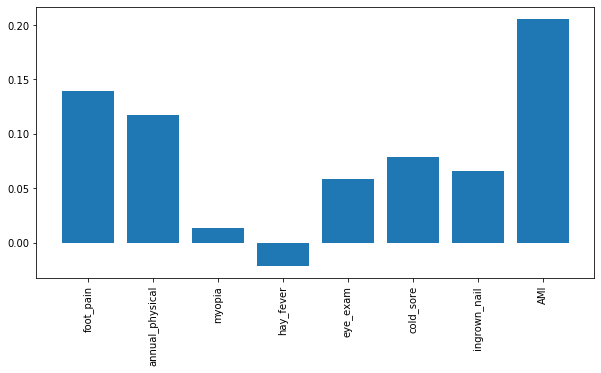

In [743]:
plt.figure(figsize=(10, 5))
plt.bar(df.token, df.R)
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 <a list of 16 Text xticklabel objects>)

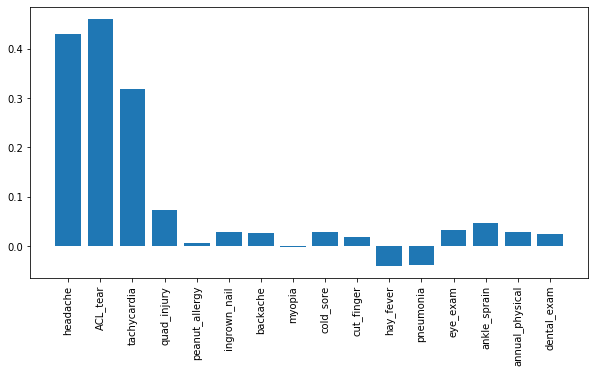

In [132]:
plt.figure(figsize=(10, 5))
plt.bar(df.token, df.R)
plt.xticks(rotation=90)

In [25]:
lstm_model_cuda = lstm_model.cuda()
lstm_model_cuda.eval()
model_pred, attn, ctxt, attn_int, out, output = lstm_model_cuda(one_text_tensor, True)
model_pred

array([[2.156011]], dtype=float32)

In [748]:
(ids, labels, idxed_text) = next(iter(test_dataloader))
sel_idxes = [x for x in range(10)]
errors = []
for sel_idx in sel_idxes:
    one_text = [int(token.numpy()) for token in idxed_text[sel_idx]]
    one_text = [x for x in one_text if x != 0]
    one_text_tensor = torch.Tensor(one_text)
    one_text_tensor = one_text_tensor.type(torch.long)
    one_text_tensor = one_text_tensor.unsqueeze(0).cuda()
    ##print(one_text)
    #print(one_text_tensor)
    #print(len(one_text))

    lrp_model.set_input(one_text)
    lrp_model.forward_lrp()
    
    Rx, Rx_rev, R_rest  = lrp_model.lrp(one_text, 0, eps= 0.00001, bias_factor=1)
    Rtot = Rx.sum() + Rx_rev.sum() + R_rest.sum()  

    errors.append(np.round(Rtot - lrp_model.s[0], 5))
    print(f"\nResults for {sel_idx}")
    #for layer in reversed(range(3)):
    #    
    #    Rtot =  lrp_model.Rx[layer].sum() + lrp_model.Rx_rev[layer][::-1,:].sum() + \
    #            (lrp_model.Rh_Left[layer][-1].sum()+lrp_model.Rc_Left[layer ][-1].sum()+ \
    #            lrp_model.Rh_Right[layer][-1].sum()+lrp_model.Rc_Right[layer][-1].sum()).sum()
    #    
    print(f"layer: {0} --> Rtot = {np.abs(Rtot)}, Score = {np.abs(lrp_model.s[0])}")
    
print('\nSummary')
print(errors)
print(np.mean(errors))


Results for 0
layer: 0 --> Rtot = 2.2437809665575403, Score = 2.243784352791791

Results for 1
layer: 0 --> Rtot = 2.2034118591056266, Score = 2.203406574265427

Results for 2
layer: 0 --> Rtot = 2.656337724625678, Score = 2.6563395236438776

Results for 3
layer: 0 --> Rtot = 2.093585277491205, Score = 2.0935874782396184

Results for 4
layer: 0 --> Rtot = 2.1534109296027557, Score = 2.1534096390216098

Results for 5
layer: 0 --> Rtot = 2.456349909866009, Score = 2.4563526138268665

Results for 6
layer: 0 --> Rtot = 3.4197476923476615, Score = 3.419742585516341

Results for 7
layer: 0 --> Rtot = 3.720195771681171, Score = 3.720185018618414

Results for 8
layer: 0 --> Rtot = 3.358242242010739, Score = 3.358237492520032

Results for 9
layer: 0 --> Rtot = 2.083760373736082, Score = 2.083757996718185

Summary
[0.0, 1e-05, 0.0, -0.0, 0.0, 0.0, -1e-05, -1e-05, -0.0, 0.0]
-1.0000000000000002e-06


**debug attn**

Final attention scores

In [24]:
attn

array([[0.08149937, 0.09841573, 0.09362625, 0.08023169, 0.09917062,
        0.07985616, 0.09651111, 0.08856925, 0.09492204, 0.04941759,
        0.01490518, 0.01438902, 0.01433434, 0.01585263, 0.01470559,
        0.01427218, 0.01510236, 0.01579659, 0.01842225]], dtype=float32)

In [25]:
lrp_model.att_score

array([0.01753611, 0.01754035, 0.0159816 , 0.01412296, 0.01859244,
       0.01822432, 0.01926234, 0.01926778, 0.02183105, 0.05254295,
       0.07326478, 0.07477356, 0.08119175, 0.07852792, 0.08867372,
       0.09165921, 0.10002027, 0.1001971 , 0.09678981])

Before normalization

In [26]:
lrp_model.att_score_int

array([-0.19836924, -0.19812712, -0.29119319, -0.41482927, -0.13987634,
       -0.15987395, -0.10447949, -0.10419691,  0.02070205,  0.89899985,
        1.23144878,  1.25183313,  1.33418243,  1.30082306,  1.42233237,
        1.45544636,  1.54274171,  1.54450808,  1.50991058])

In [27]:
attn_int

array([[ 1.3992885 ,  1.587894  ,  1.538004  ,  1.3836118 ,  1.595535  ,
         1.3789202 ,  1.5683514 ,  1.4824779 ,  1.5517491 ,  0.89899975,
        -0.29959828, -0.33484167, -0.33864853, -0.23797123, -0.31307918,
        -0.34299457, -0.28645557, -0.24151303, -0.08774745]],
      dtype=float32)

Query- OK, the same

In [29]:
lrp_model.h_Left[len(one_text)-1]

array([-4.56225493e-03, -5.88411946e-05,  3.38443218e-02, -7.45028679e-03,
        2.33660989e-05, -6.35983403e-01,  1.75865722e-01,  4.46616500e-01,
        3.25537945e-03,  2.23170496e-01, -5.26650655e-02,  8.26347271e-02,
       -3.00173144e-02, -3.19712192e-01, -1.04870946e-02,  1.54069476e-03])

In [30]:
lrp_model.h_Right[len(one_text)-1]

array([ 9.86988855e-01,  1.56019730e-04, -9.70274949e-01, -5.10828600e-04,
        1.36936581e-02, -9.88427582e-01,  7.26517466e-01, -9.99589538e-01,
       -3.84301741e-05, -1.84636200e-01,  3.02444066e-01,  7.51164132e-01,
        3.07978058e-01, -2.64226348e-03, -7.60510172e-01, -9.75990615e-04])

In [31]:
out

array([[-4.5622555e-03, -5.8841215e-05,  3.3844326e-02, -7.4502863e-03,
         2.3366092e-05, -6.3598347e-01,  1.7586571e-01,  4.4661650e-01,
         3.2553808e-03,  2.2317050e-01, -5.2665066e-02,  8.2634732e-02,
        -3.0017309e-02, -3.1971222e-01, -1.0487095e-02,  1.5406949e-03,
         9.8698884e-01,  1.5601973e-04, -9.7027487e-01, -5.1082874e-04,
         1.3693659e-02, -9.8842758e-01,  7.2651744e-01, -9.9958944e-01,
        -3.8430193e-05, -1.8463618e-01,  3.0244407e-01,  7.5116402e-01,
         3.0797806e-01, -2.6422644e-03, -7.6051033e-01, -9.7599073e-04]],
      dtype=float32)

In [59]:
out.shape

(1, 32)

Key - OK, same

In [34]:
lrp_model.h_Left[0]

array([-0.00440368, -0.00077483,  0.01025761, -0.01648366,  0.00042234,
       -0.11363921,  0.04486908,  0.25828355,  0.01791407,  0.10618368,
       -0.31055342,  0.17926648, -0.0116319 , -0.19949458, -0.14052975,
        0.00904198])

In [38]:
output[0][0, :16]

array([-0.00440368, -0.00077483,  0.01025761, -0.01648366,  0.00042234,
       -0.11363921,  0.04486908,  0.25828356,  0.01791408,  0.10618369,
       -0.31055343,  0.1792665 , -0.0116319 , -0.1994946 , -0.14052972,
        0.00904198], dtype=float32)

In [48]:
output.shape

(1, 19, 32)

In [81]:
np.allclose(output[0][:, :16], lrp_model.h_Left[:len(one_text)])

True

Multiplication of key and query

In [51]:
attn_int

array([[ 1.3992885 ,  1.587894  ,  1.538004  ,  1.3836118 ,  1.595535  ,
         1.3789202 ,  1.5683514 ,  1.4824779 ,  1.5517491 ,  0.89899975,
        -0.29959828, -0.33484167, -0.33864853, -0.23797123, -0.31307918,
        -0.34299457, -0.28645557, -0.24151303, -0.08774745]],
      dtype=float32)

In [58]:
torch.bmm(torch.tensor(output), torch.tensor(out).unsqueeze(2)).squeeze(2) / ((len(one_text)) ** 0.5)

tensor([[ 1.3993,  1.5879,  1.5380,  1.3836,  1.5955,  1.3789,  1.5684,  1.4825,
          1.5517,  0.8990, -0.2996, -0.3348, -0.3386, -0.2380, -0.3131, -0.3430,
         -0.2865, -0.2415, -0.0877]])

LEFT

In [97]:
left = torch.bmm(
    torch.tensor(output[:, :, :16]),
    torch.tensor(out[:, :16]).unsqueeze(2)).squeeze(2)# / ((len(one_text)) ** 0.5)
left

tensor([[ 0.3165,  0.9793,  0.7821,  0.3520,  0.9874,  0.4492,  0.9839,  0.8038,
          0.9782, -0.6185, -0.4180, -0.2015, -0.0368,  0.1088,  0.2324,  0.6652,
          0.8028,  0.7901,  0.7987]])

In [95]:
torch.tensor(out[:, :16]).unsqueeze(2).shape

torch.Size([1, 16, 1])

In [87]:
left.shape

torch.Size([1, 19])

RIGHT

In [99]:
right = torch.bmm(
    torch.tensor(output[:, :, 16:]),
    torch.tensor(out[:, 16:]).unsqueeze(2)).squeeze(2) 
right

tensor([[ 5.7828,  5.9422,  5.9219,  5.6790,  5.9674,  5.5614,  5.8524,  5.6581,
          5.7857,  4.5372, -0.8879, -1.2580, -1.4393, -1.1460, -1.5971, -2.1602,
         -2.0514, -1.8429, -1.1812]])

In [66]:
left + right

tensor([[ 1.3993,  1.5879,  1.5380,  1.3836,  1.5955,  1.3789,  1.5684,  1.4825,
          1.5517,  0.8990, -0.2996, -0.3348, -0.3386, -0.2380, -0.3131, -0.3430,
         -0.2865, -0.2415, -0.0877]])

Left should match lrp left

In [83]:
lrp_model.h_Left[:len(one_text)].shape

(19, 16)

In [85]:
lrp_model.h_Left[len(one_text)-1].shape

(16,)

In [92]:
np.dot(lrp_model.h_Left[:len(one_text)], lrp_model.h_Left[len(one_text)-1])

array([ 0.31654942,  0.97925445,  0.78214506,  0.35203534,  0.98742115,
        0.44917446,  0.98388902,  0.8038423 ,  0.97818387, -0.61853069,
       -0.41797293, -0.20151502, -0.03683031,  0.10875611,  0.23244751,
        0.66515558,  0.8027958 ,  0.79013921,  0.79873875])

In [98]:
np.dot(lrp_model.h_Right[:len(one_text)], lrp_model.h_Right[len(one_text)-1])

array([-1.18122091, -1.84287054, -2.05142676, -2.16023422, -1.59712796,
       -1.14604887, -1.43930458, -1.2580261 , -0.88794573,  4.53718016,
        5.78573373,  5.65812912,  5.85239671,  5.56140014,  5.96735554,
        5.678988  ,  5.92185941,  5.94221543,  5.78280887])

In [47]:
(np.matmul(lrp_model.h_Left[:len(one_text), :], lrp_model.h_Left[len(one_text)-1]) +
 np.matmul(lrp_model.h_Right[:len(one_text), :], lrp_model.h_Right[len(one_text)-1]))

array([-0.86467149, -0.86361608, -1.2692817 , -1.80819888, -0.60970682,
       -0.69687441, -0.45541555, -0.4541838 ,  0.09023814,  3.91864948,
        5.3677608 ,  5.4566141 ,  5.81556641,  5.67015625,  6.19980305,
        6.34414359,  6.72465522,  6.73235464,  6.58154763])

In [44]:
lrp_model.h_Left[len(one_text)-1].shape

(16,)

**debug ctxt**

In [26]:
lrp_model.ctxt_Left + lrp_model.ctxt_Right

array([-0.75175912, -0.22730606,  0.07156486,  0.07396148, -0.04116775,
       -0.71445155, -0.78800423,  0.10803136, -0.1190088 ,  0.01892237,
       -0.21002502,  0.04333301,  0.08290456, -0.00852125,  0.20073836,
        0.60271534])

In [27]:
ctxt

array([[-2.84175336e-01, -4.38186899e-02,  3.77291726e-04,
         5.38268089e-02, -1.51431382e-01,  7.09627271e-02,
        -2.15149652e-02, -2.02006251e-01, -1.28047355e-02,
         5.87341143e-03, -1.04134284e-01, -1.61383096e-02,
         4.89300601e-02, -3.07334140e-02, -3.16762067e-02,
         2.89033055e-01, -2.89291516e-03, -4.57919165e-02,
         7.35101253e-02, -5.01201674e-02,  2.72683412e-01,
        -2.71461427e-01, -4.09775704e-01,  3.68046999e-01,
        -5.83853945e-02,  6.36376953e-03,  3.26851718e-02,
         5.70958629e-02,  5.62404357e-02, -4.56434265e-02,
         8.26789588e-02, -5.07154986e-02]], dtype=float32)

In [133]:
lrp_model.att_wgt_Left

array([-0.31218773, -0.39379643, -0.67169792, -0.37530512, -0.5557664 ,
       -0.53200644, -0.48169229, -0.69452818, -0.43692519,  3.49979837,
        3.80953519,  3.99241767,  4.03306182,  3.94953208,  4.01828531,
        3.98317122,  3.97800063,  3.92579031,  3.92395222])

In [134]:
lrp_model.att_score_int

array([-0.25089944, -0.30539514, -0.42103811, -0.37277385, -0.38318346,
       -0.31277025, -0.3360959 , -0.40667137, -0.35669475,  1.36670953,
        1.51176272,  1.52928085,  1.56859521,  1.54885829,  1.57262714,
        1.53593461,  1.5601841 ,  1.55118622,  1.52509087])

In [117]:
lrp_model.att_score

array([0.01482975, 0.01404322, 0.0125096 , 0.01312818, 0.01299223,
       0.01394003, 0.01361863, 0.01269062, 0.01334097, 0.0747571 ,
       0.08642677, 0.08795414, 0.09148087, 0.08969302, 0.09185046,
       0.08854132, 0.09071464, 0.08990207, 0.08758638])

In [89]:
import torch.nn as nn

In [91]:
nn.functional.softmax(torch.tensor(lrp_model.att_score_int))

tensor([0.0148, 0.0140, 0.0125, 0.0131, 0.0130, 0.0139, 0.0136, 0.0127, 0.0133,
        0.0748, 0.0864, 0.0880, 0.0915, 0.0897, 0.0919, 0.0885, 0.0907, 0.0899,
        0.0876], dtype=torch.float64)

In [75]:
np.abs(lrp_pred - model_pred.cpu().detach().numpy())

array([[1.17925553]])

In [21]:
Rx, Rx_rev, R_rest  = lrp_model.lrp(one_text, 0)

In [22]:
R_words             = np.sum(Rx + Rx_rev, axis=1) 

In [23]:
import pandas as pd

In [24]:
df = pd.DataFrame()
df['R'] = R_words
df['idx'] = one_text
df['token'] = [lstm_model.vocab.itos(x) for x in one_text]

In [25]:
df.head()

,R,idx,token
0,0.133912,12,ankle_sprain
1,0.002906,5,PH
2,0.073714,12,ankle_sprain
3,0.046349,11,peanut_allergy
4,-0.060053,20,foot_pain


([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

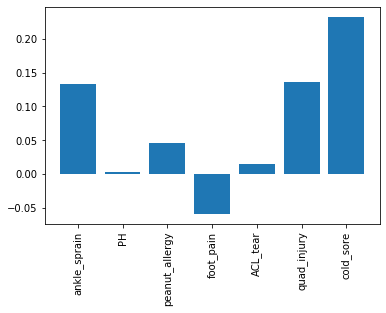

In [26]:
plt.figure()
plt.bar(df.token, df.R)
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

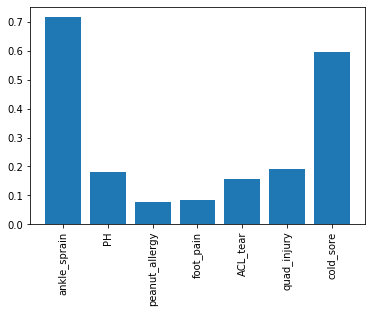

In [190]:
plt.figure()
plt.bar(df.token, df.R)
plt.xticks(rotation=90)